# Poondi lake

<img src="../assets/poondi.jpg" width="1400px">

Poondi Reservoir (later named as Sathyamoorthy Sagar) was constructed in 1944 across the Kosathalaiyar River or Kotralai River in Thiruvallur district with a capacity of 2573 Mcft and placed in service for intercepting and storing Kosathalaiyar River water. Surplus water flows down the river which is again intercepted by Tamaraipakkam Anicut and diverted to Sholavaram Lake and Puzhal lake.The original structure is thought to be constructed in the 16th Century. [source](https://chennaimetrowater.tn.gov.in/online_water_taxpayment.html)

---

## Table of Contents


1. [Loading packages and data](#Loading-packages-and-data)
1. [EDA](#EDA)
1. [Model Preparation](#Model-Preparation)
1. [Time-Series](#Time-Series)
1. [Modeling](#Modeling)
   - [Baseline](#Baseline)
   - [ARIMA](#ARIMA) 
1. [Model Selection](#Model-Selection)
1. [Model evaluation](#Model-evaluation)
   - [Looking at the Residuals](#Looking-at-the-Residuals)
   - [Visualizing Predictions](#Visualizing-Predictions)


## Loading packages and data

---

In [2]:
import pandas as pd # packages for reading in data
import numpy as np
import matplotlib.pyplot as plt  # packages for displaying data
from matplotlib.patches import Rectangle
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import acf, pacf #packages for statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score,  mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pandas.plotting import autocorrelation_plot

sns.set_style("darkgrid") # setting style

---

#### Reading in data

In [3]:
df = pd.read_csv("../data/chennai_complete.csv",index_col='date',parse_dates=True, # setting the index to datetime
                 usecols=['date','poondi_water','poondi_rain']) # selecting columns

We are reading the data and selecting the relevant columns and setting the date to a DateTime and making that column our data frame's index. We need to do this because we are working with this data as a time-series.

We already cleaned our data in the main notebook so we can go straight into the EDA. 

---

## EDA

These lines of code are functions for plotting.

In [4]:
def plot_line(df, col, x_label, y_label, title):
    df[col].plot(figsize=(20,10))
    plt.title(title ,fontsize=15) #plotting title
    plt.xlabel(x_label,fontsize=15)
    plt.ylabel(y_label,fontsize=15);

In [5]:
def graph_percentile(col):
    #modified code into a function from https://towardsdatascience.com/practical-statistics-visualization-with-python-plotly-770e96e35067
    # data
    data = col

    # Colours for different percentiles
    perc_25_colour = 'gold'
    perc_50_colour = 'mediumaquamarine'
    perc_75_colour = 'deepskyblue'
    perc_95_colour = 'peachpuff'

    # Plot the Histogram from the random data
    fig, ax = plt.subplots(figsize=(8,8))

    '''
    counts  = numpy.ndarray of count of data ponts for each bin/column in the histogram
    bins    = numpy.ndarray of bin edge/range values
    patches = a list of Patch objects.
            each Patch object contains a Rectnagle object. 
            e.g. Rectangle(xy=(-2.51953, 0), width=0.501013, height=3, angle=0)
    '''
    counts, bins, patches = ax.hist(data, facecolor=perc_50_colour, edgecolor='gray')
    a = col.name.replace("_"," ")

    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins.round(2))
    plt.xticks(rotation=70)

    # Set the graph title and axes titles
    plt.title(f'Distribution of rainfall for {a} reservoir in millimetres', fontsize=20)
    plt.ylabel('Count of Distribution', fontsize=15)
    plt.xlabel('Amount rainfall in millimetres', fontsize=15)

    # Change the colors of bars at the edges
    twentyfifth, seventyfifth, ninetyfifth = np.percentile(data, [25, 75, 95])
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside < twentyfifth:
            patch.set_facecolor(perc_25_colour)
        elif leftside > ninetyfifth:
            patch.set_facecolor(perc_95_colour)
        elif leftside > seventyfifth:
            patch.set_facecolor(perc_75_colour)

    # Calculate bar centre to display the count of data points and %
    bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
    bin_y_centers = ax.get_yticks()[1] * 0.25

    # Display the the count of data points and % for each bar in histogram
    for i in range(len(bins)-1):
        bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
        plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

    # Annotation for bar values
    ax.annotate('Each bar shows count and percentage of total',
                xy=(.85,.30), xycoords='figure fraction',
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=10, bbox=dict(boxstyle="round", fc="white"),
                rotation=-90)

    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [perc_25_colour, perc_50_colour, perc_75_colour, perc_95_colour]]
    labels= ["0-25 Percentile","25-50 Percentile", "50-75 Percentile", ">95 Percentile"]
    plt.legend(handles, labels, bbox_to_anchor=(0.5, 0., 0.80, 0.99))



In [6]:
def hist_plot(df, cols, x_label, y_label, title):
    plt.figure(figsize=(15,6))
    ax = sns.distplot(df[[cols]], kde=False); #making a plot based of the distrabution
    ax.set(xlabel=x_label, ylabel =  y_label, title=title) #average
    plt.axvline(df[cols].mean(), color = 'red');

---

In [7]:
df.shape


(5836, 2)

Our data has 5836 rows of data with two columns corresponding to the rain and daily water level of poondi lake. The data starts in 2004 and goes until 2019.

For our particular problem, we are going to resample the data to months, but I thought it would be interesting first to see the data as it is.

In [8]:
df.describe()

poondi_water  poondi_rain
count   5836.000000  5836.000000
mean    1116.271270     3.464402
std     1020.316805    13.065897
min        0.900000     0.000000
25%      200.225000     0.000000
50%      775.500000     0.000000
75%     1975.000000     0.000000
max     3231.000000   300.000000


Looking at the percentiles one is first drawn to the rainfall feature. There seems to be a dramatic picture of all zeros until we get to the maximum value. Only then is there a non-zero value present.

This led us to check the total number of zeros contained in the rainfall feature.

In [9]:
df.eq(0).sum()

poondi_water       0
poondi_rain     4647
dtype: int64

4720 of the rain data out of our total data of 5836 is a zero value.


This led us to go on and visualize the distribution of the rain and see what sort of values we had.

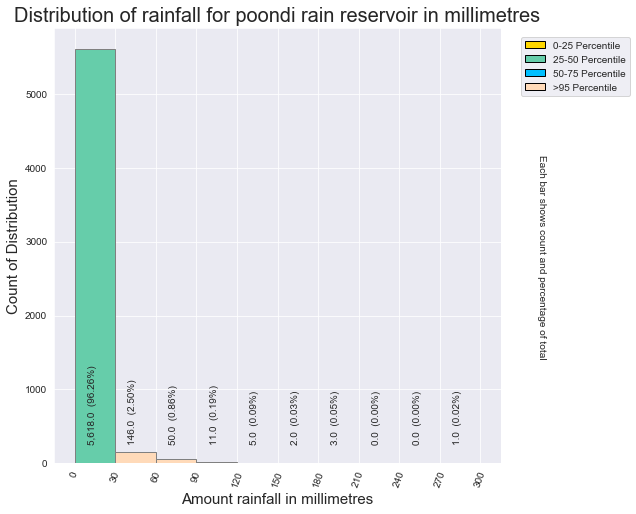

In [10]:
graph_percentile(df["poondi_rain"])


As can be seen, most of the values are zero values followed by smaller and smaller amounts of progressively higher values, with a handful of values being over 142 millimeters.

This begs the question of how these values are distributed across the years.

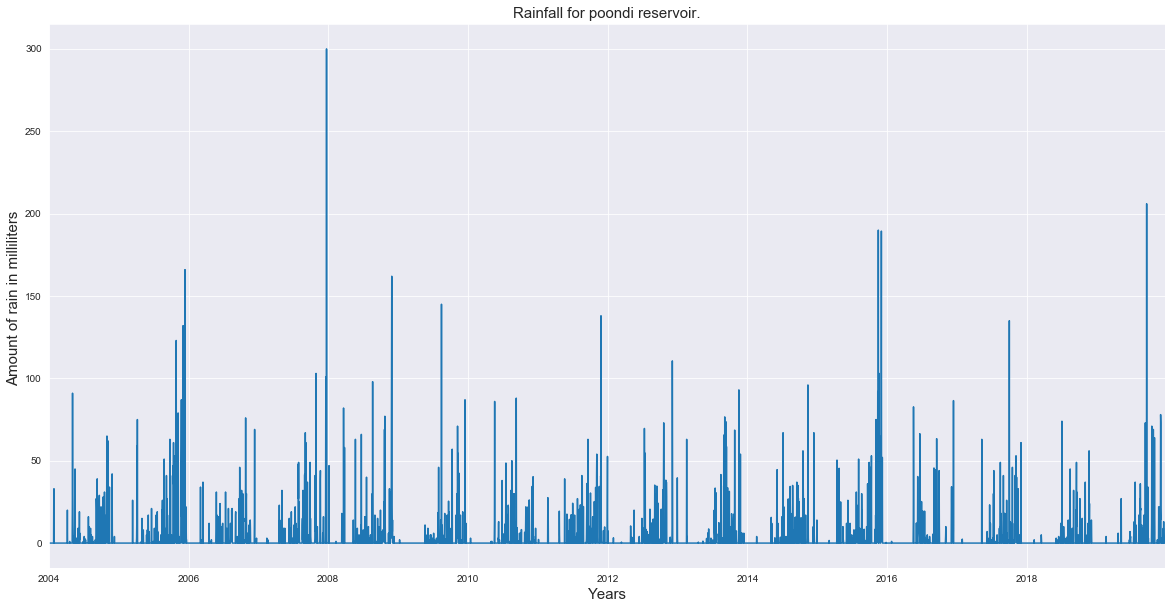

In [11]:
plot_line(df,"poondi_rain", "Years", "Amount of rain in milliliters ", "Rainfall for poondi reservoir.")

Over here we can see that the rainfall is represented by sharp peaks and flat lines. A good portion of the year has little to no rain followed by a large amount of rain over a repeated specific amount of time.

This trend is made clearer when we look at an individual years.

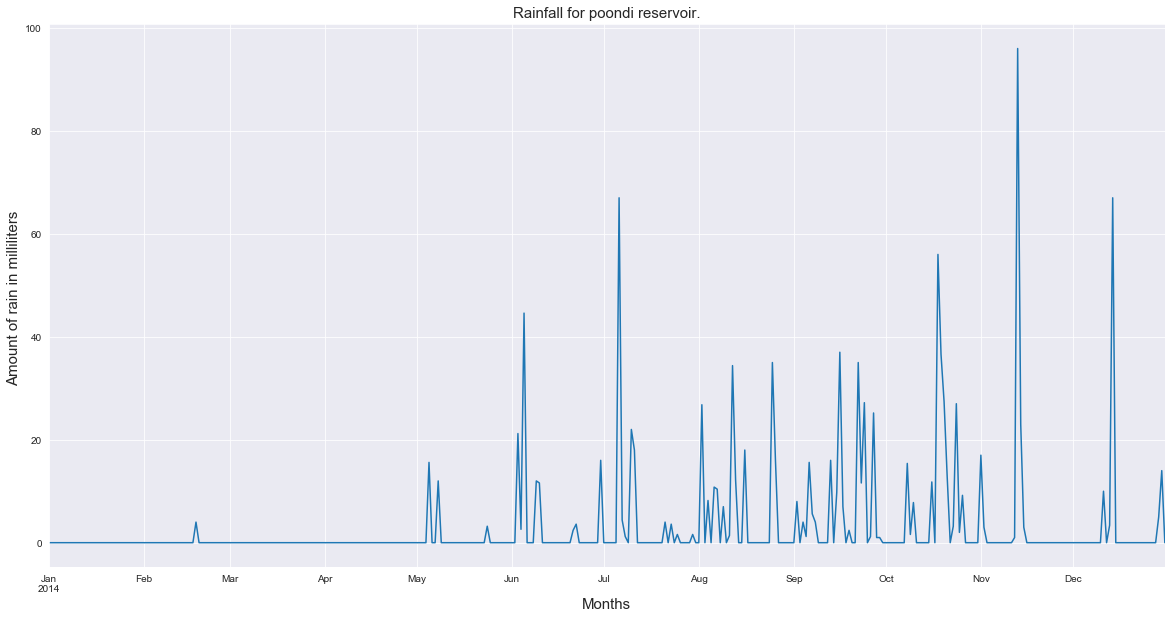

In [12]:
plot_line(df.loc['2014'],"poondi_rain", "Months", "Amount of rain in milliliters ", "Rainfall for poondi reservoir.")

Looking at the daily rains for 2014, we see that it rains in the month of June, July, August and September. This is due to south west monsoon.            
Major rainfall also happens during October and November of every year which is due to North-east monsoon. 

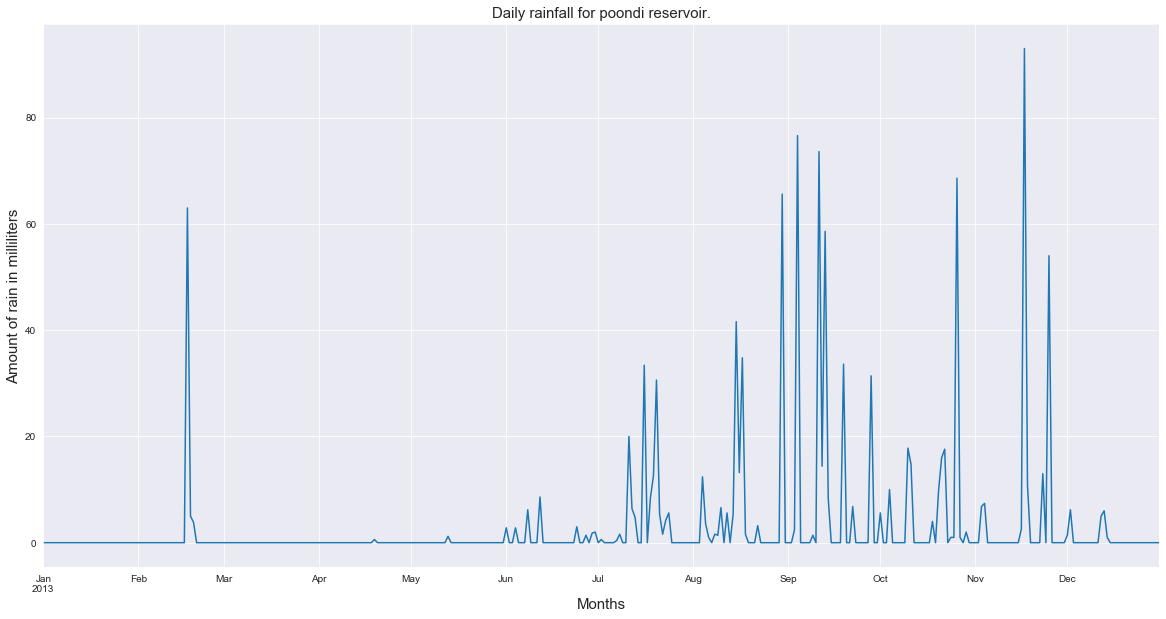

In [13]:
plot_line(df.loc['2013'],"poondi_rain", "Months", "Amount of rain in milliliters", "Daily rainfall for poondi reservoir.")

Looking at the daily rains for 2013, we see similar findings.

All these findings make sense as India only gets on average rainfall for 54 days out of the year. The time that it does get rain it comes in the form of 2 monsoons.

This isn't to say that every year is the same. Looking at the first graph one can see that there is a massive spike in 2015. This corresponds to the massive floods that occurred throughout November and December in Chennai.

---

Moving on, we will now look at the target feature in our data the water level of the reservoir.


The appears to a lot of zero values but not nearly as many as with the rainfall values. Also, the most frequent values are low values between 0 and 500. The distribution isn't normal with a skew to the right. The average is about 1300 and a max and min of 3000 and 0 respectively.

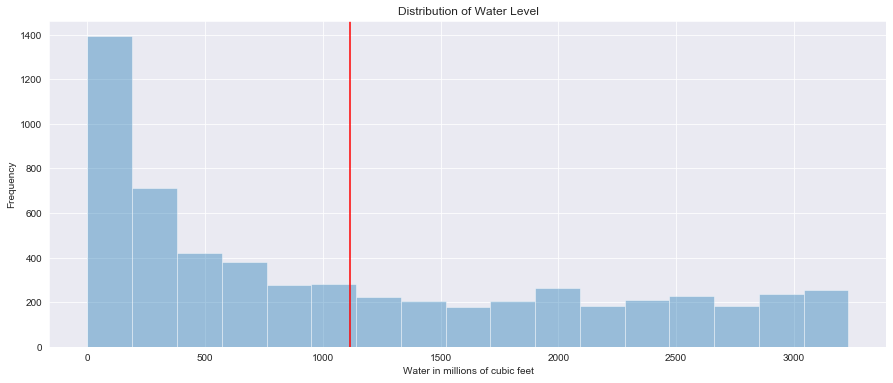

In [14]:
hist_plot(df, "poondi_water", "Water in millions of cubic feet","Frequency","Distribution of Water Level")


For our problem statement, we are trying to predict the average monthly water level in each reservoir so we are going to resample  our data to the average monthly total.

In [15]:
df_m = df.resample("m").mean()

In [16]:
df.describe()

poondi_water  poondi_rain
count   5836.000000  5836.000000
mean    1116.271270     3.464402
std     1020.316805    13.065897
min        0.900000     0.000000
25%      200.225000     0.000000
50%      775.500000     0.000000
75%     1975.000000     0.000000
max     3231.000000   300.000000

In [17]:
df_m.describe()

poondi_water  poondi_rain
count    192.000000   192.000000
mean    1118.908370     3.457630
std     1007.616869     4.100004
min        2.464516     0.000000
25%      239.104167     0.142627
50%      775.390860     2.358065
75%     1935.640860     5.460215
max     3225.870968    28.923333

We now have a data frame consisting of an average for rain and water level for 192 months.

Most notably the percentiles in the rain column are now not zero.

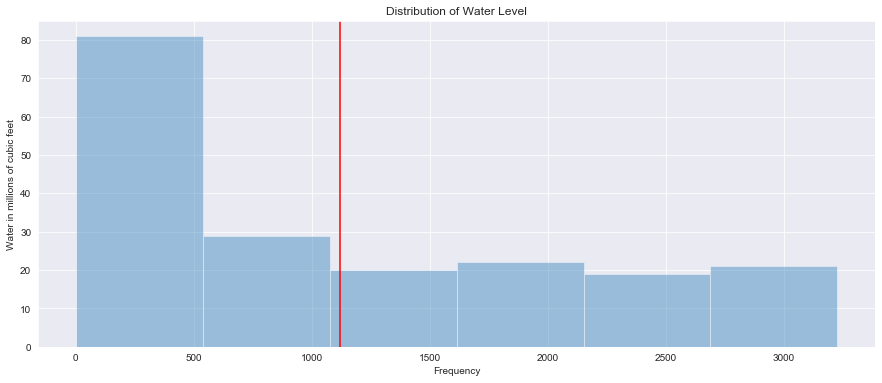

In [18]:
hist_plot(df_m, "poondi_water", "Frequency", "Water in millions of cubic feet","Distribution of Water Level")

The graph looks different than before.

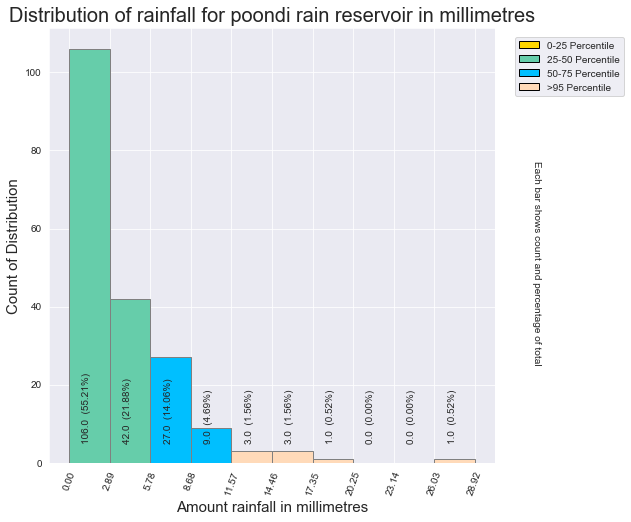

In [19]:
graph_percentile(df_m["poondi_rain"])

However, by the graph for the rain, there is a great change as now we are looking at the monthly average and not daily, so the days where there was a massive outpour is more spread out.  

---

Now we are going to look at the monthly data.

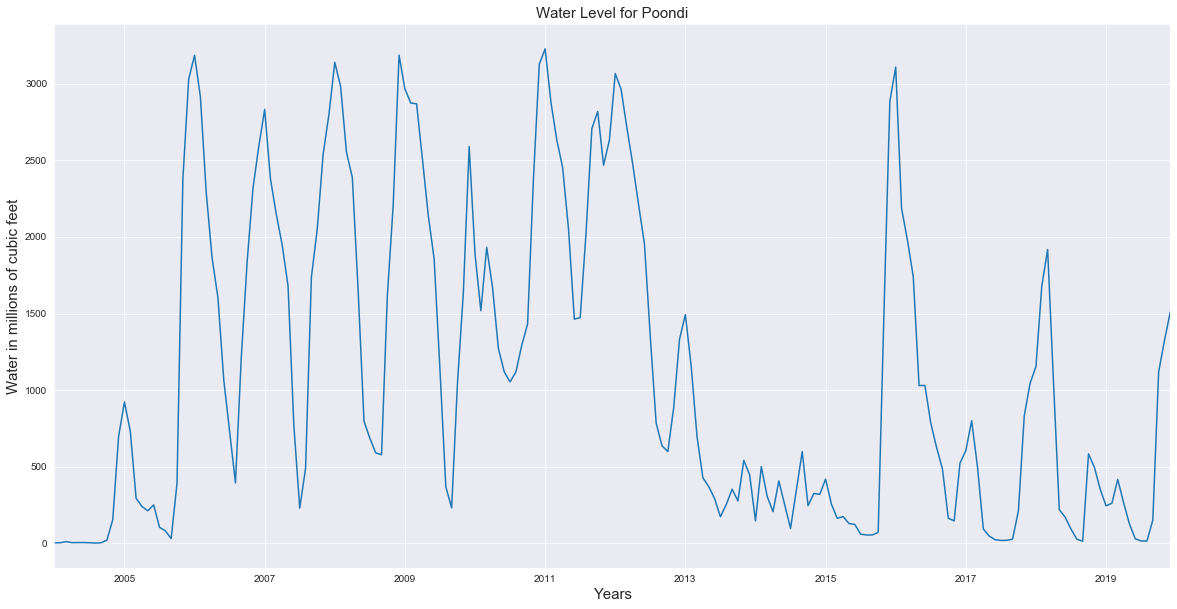

In [20]:
plot_line(df_m,"poondi_water", "Years", 
          "Water in millions of cubic feet",
          "Water Level for Poondi" )

Looking at the graph we can see several spikes above and below the average of 1300 cubic million feet.

Notable outliers include the times where the water level was zero or near zero in 2004, 2005, and most recently in 2019.

---

We are now going to look at the year of the water crisis, 2019.

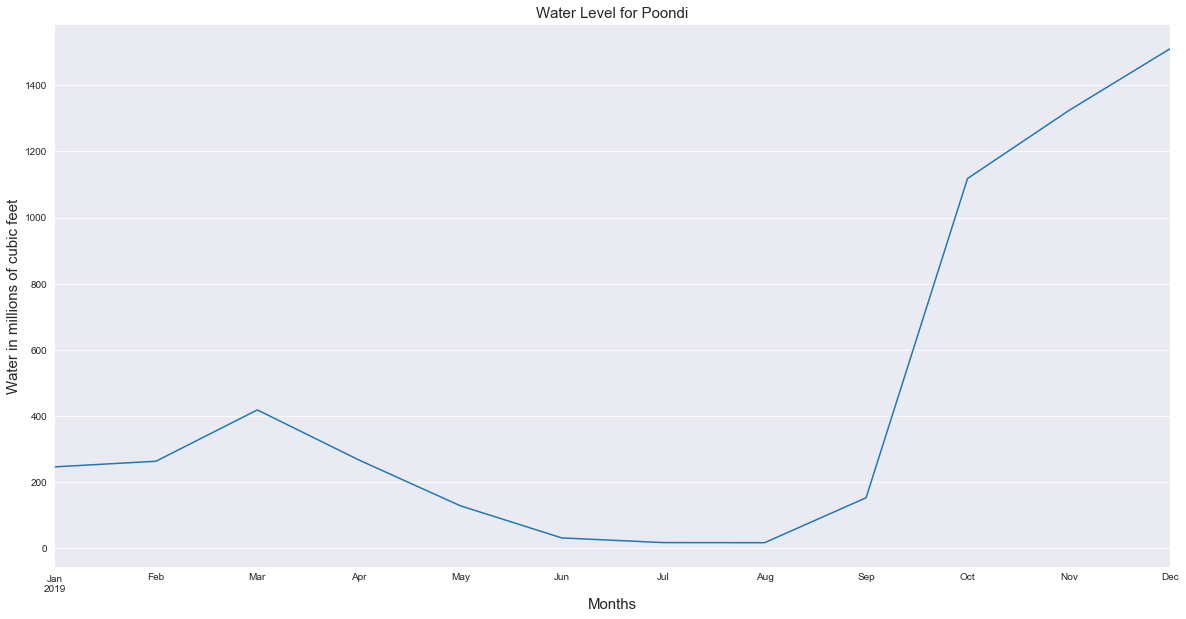

In [21]:
plot_line(df_m.loc["2019"],"poondi_water", "Months", 
          "Water in millions of cubic feet",
          "Water Level for Poondi") 

We can see that the water level was very low with the year starting at below 100 and flatting out to around 0 towards the end of April. The water level than rose toward the end of the year.

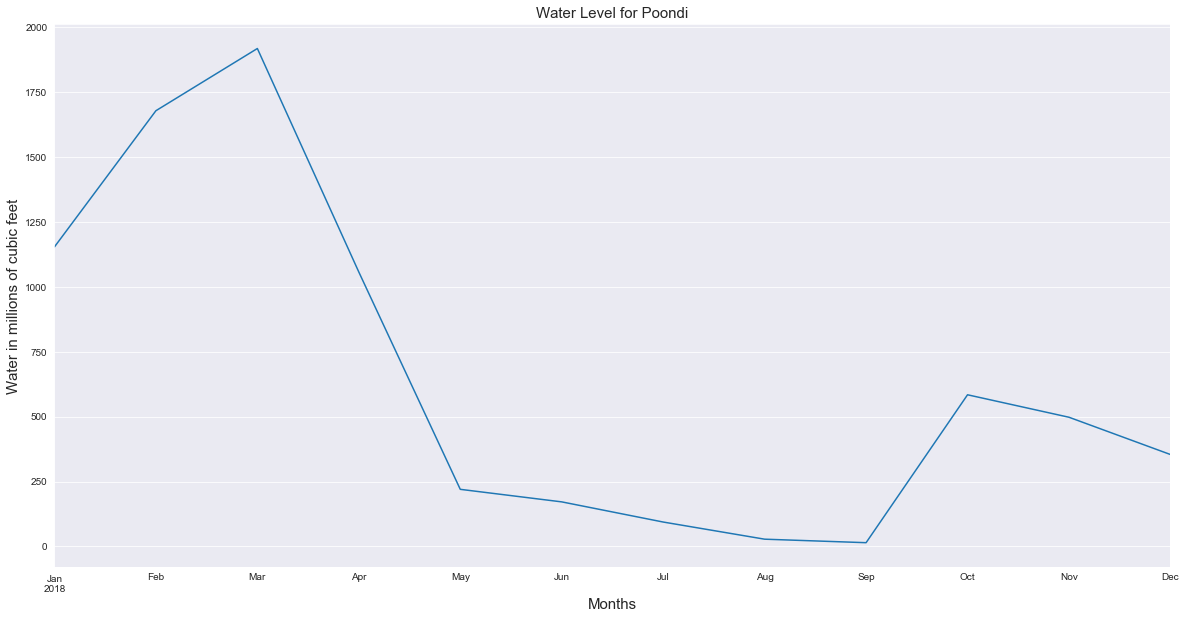

In [22]:
plot_line(df_m.loc["2018"],"poondi_water", "Months", 
          "Water in millions of cubic feet",
          "Water Level for Poondi") 

The previous year of 2018 started lower than dropped until May and than after a brief gain plummeted exponentially for the rest of the year.

If we look at the rainfall we can see that it corresponds with the rise and fall of the water level.

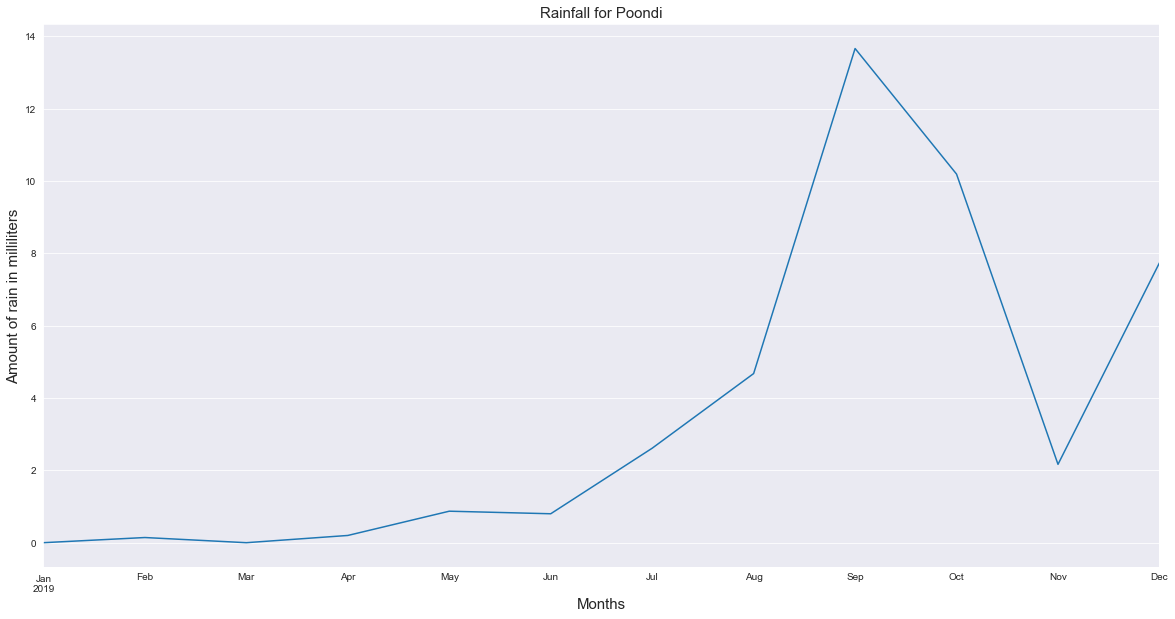

In [23]:
plot_line(df_m.loc["2019"],"poondi_rain", "Months", 
          "Amount of rain in milliliters",
          "Rainfall for Poondi") 

The rainfall is flatlined at zero and only really rises after May. The hard rainfall in October contributed to the water level rising later that year.

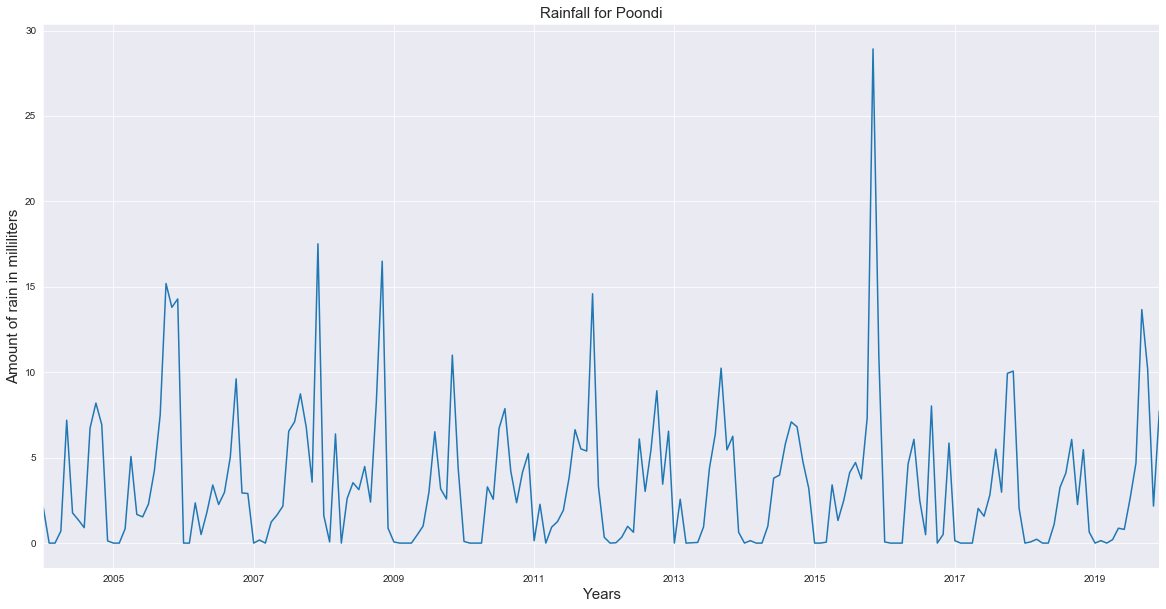

In [24]:
plot_line(df_m,"poondi_rain", "Years", 
          "Amount of rain in milliliters",
          "Rainfall for Poondi") 

---

Of the biggest factors that have caused water scarcity in Chennai, in addition to poor rains and water management, is the development of the city and population growth that has occurred in recent decades.

<img src="../assets/ch.gif" width="500px">
<img src="../assets/CHennaiGIF.gif" width="500px">


After going through the data we can see the following:

* The city gets some rains in the month of June, July, August and September due to south west monsoon.  

* Major rainfall happens during October and November of every year which is due to North-east monsoon.  
* During the initial years rain from north-east monsoon is much higher than south-west monsoon. But seems like in the last few years, they both are similar.


---

## Time-Series 

Before we get into the modeling there are somethings we have to address due to the nature of time-series data.

####  Checking for Stationarity

Stationarity is an important assumption when working with time-series data.
Later on in the project, the model will not work properly unless the time data is stationary.



One way to determine stationary is to implement the Augmented Dickey-Fuller test.

A **small $p$-value** (**<.05**) in the test would give us evidence and tell us to reject the null hypothesis, meaning we accept that **our time series is indeed stationary**

In [25]:
adfuller(df_m["poondi_water"])

(-2.181849005342621,
 0.2128990487830274,
 12,
 179,
 {'1%': -3.4674201432469816,
  '5%': -2.877826051844538,
  '10%': -2.575452082332012},
 2580.7127965923783)

**Interpretation**: the number given is .12 which is greater than .5 so we are confident that our data is not stationary

We now need to difference to get the raw data to be stationary.

In [44]:
adfuller(df_m["poondi_water"].diff(1).dropna())

(-8.345484459336229,
 3.0937180095855435e-13,
 8,
 182,
 {'1%': -3.4668001583460613,
  '5%': -2.8775552336674317,
  '10%': -2.5753075498128246},
 2569.345046710506)

The number given is  < .05  so we 95% confident that our data is stationary.

#### Plotting ACF, PACF

Before we model, we want to see if there are any trends and lags that can feed into the AR and MA parts of our ARIMA model. We are doing this plotting both the auto-correlation function and partial auto-correlation function.

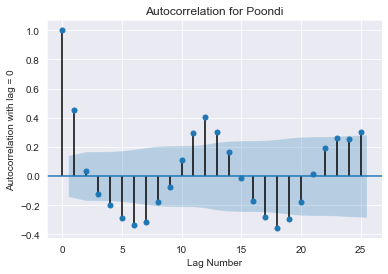

In [27]:
plot_acf(df_m['poondi_water'].diff(1).dropna(), lags =25)
plt.xlabel("Lag Number")
plt.ylabel("Autocorrelation with lag = 0")
plt.title("Autocorrelation for Poondi");

**Interpretation**: The plot seems is trending up and down.

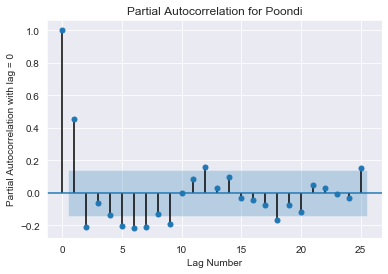

In [28]:
plot_pacf(df_m['poondi_water'].diff(1).dropna(), lags = 25)
plt.xlabel("Lag Number")
plt.ylabel("Partial Autocorrelation with lag = 0")
plt.title("Partial Autocorrelation for Poondi");

**Interpretation**: The Partial-autocorrelation Function plot is showing here that there are significant lags at 1, 12, 23, 24, months. We can see this based on the point being outside of the 95% confidence interval represented by the blue. 

## Modeling
---

### Baseline

Before we model, we are going to establish a baseline model by which to compare all other results.

In [53]:
df_dumb = df_m["poondi_water"].diff(1).dropna()

We are making a data frame and shifting one of the columns and lagging it by one.

In [54]:
values = df_dumb
dataframe = pd.concat([values.shift(1), values], axis=1) #lagging the data a mont
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))

                   t       t+1
date                          
2004-02-29       NaN  0.830256
2004-03-31  0.830256  7.281357
2004-04-30  7.281357 -6.273656
2004-05-31 -6.273656  0.203978
2004-06-30  0.203978  0.176022


In [55]:
X = dataframe['t+1']
y= dataframe['t']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .34, shuffle = False)

In [57]:
test_score = mean_squared_error(y_test, X_test)
print(f'Test MSE: {test_score}')

Test MSE: 188554.23573855


**Interpretation**: This Baseline Model is the simplest possible model, lagging the data for one month and predicting the next month. This model has a MSE of 188554.23 which we will use as a benchmark for future models.

### ARIMA

---

#### Model Pre-processing 

We are now going to be modeling our time-series data with an ARIMA Model.

An ARIMA model has three components:

1.  AR: Autoregressive. This means we regress the target variable on its own past values. In our case lagging a month or months of data.     
     
       

2.  I: Integrated. This shows we are differencing the data.       
   
 
3. MA: Moving Average. This is a model that forecasts Y using our modelâ€™s past errors to correct our model's forecast.

In [34]:
y = df_m["poondi_water"]

y_train, y_test = train_test_split(y, test_size = .34, shuffle = False)

Now that we have split the data, we can run the Auto ARIMA and get an optimal p,q,d order for our ARIMA model.

In [35]:
fitted_arima = auto_arima(
    y_train, # data
    start_p = 0,
    start_q = 0,
    max_p = 2,
    max_q = 2,
    d = 1, 
    stationary = False, # in this case our data is  stationary
    seasonal=True, 
    solver='lbfgs', 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True  
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1886.078, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1856.602, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1856.551, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1884.081, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1855.791, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1840.774, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1854.530, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1834.251, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1857.338, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1831.759, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1855.338, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1838.786, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1853.791, Time=0.04 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 0.906 seconds


---

Now we are fitting our ARIMA model on the training data and generating rolling forecasts for each point in the test data. We are iterating through each observation and storing the observation.

In [60]:
X = df_m.poondi_water.values # getting the values

size = int(len(X) * 0.66) 

train, test = X[0:size], X[size:len(X)] 
    
history =  list(train) # making the train into a list 

predictions = list() #setting up a list for the predictions

for t in range(len(test)): #using the len of the testset to iterate through testing data
    
    model = ARIMA(history, order=(0,1,1)) # Instantiating model
    
    model_fit = model.fit(disp=0) #fitting model and stopping display data
    
    output = model_fit.forecast() #forcasting 
    
    yhat = output[0] #feeding the predictions into the variable
    
    predictions.append(yhat) #appending the predictions to the list we create
    
    obs = test[t] 
    
    history.append(obs) #appending on to the train list
    
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions) #calculating  rmse

print(f'Test MSE: {error}') #printing the rmse


predicted=145.887590, expected=98.193548
predicted=76.687962, expected=350.903226
predicted=481.752065, expected=599.700000
predicted=659.439828, expected=246.612903
predicted=55.177854, expected=326.266667
predicted=454.135631, expected=320.322581
predicted=261.109958, expected=419.580645
predicted=495.557232, expected=255.892857
predicted=147.972963, expected=163.967742
predicted=172.428610, expected=175.333333
predicted=177.911544, expected=130.258065
predicted=109.279294, expected=124.300000
predicted=132.035609, expected=60.451613
predicted=27.953910, expected=55.419355
predicted=68.381925, expected=55.666667
predicted=50.218628, expected=72.483871
predicted=83.160772, expected=1520.500000
predicted=2193.396249, expected=2884.451613
predicted=3223.013762, expected=3107.096774
predicted=3072.186602, expected=2187.172414
predicted=1769.875998, expected=1980.387097
predicted=2094.106032, expected=1741.466667
predicted=1585.674459, expected=1030.322581
predicted=769.017677, expected=1

**Interpretation**: Our model got an MSE score of 121584.30; this is better than the baseline of 188554.2. 

The next steps would be:
 
* to further tune the p, d, q  
* to gather more data  
* to forecast over different periods.  


---

## Model Selection
---

We are selecting the ARIMA model for evaluation.

## Model Evaluation 
---

#### Looking at the Residuals

In [61]:
residuals = pd.DataFrame(model_fit.resid)

When we look at the residuals, we are primarily interested in looking at the mean. A mean value close to zero would suggest no bias in the forecast.

In [62]:
print(residuals.describe())

                 0
count   190.000000
mean      0.022266
std     381.335217
min   -1122.342395
25%    -203.280724
50%     -14.334457
75%     135.640564
max    1783.184986


**Interpretation**: Looking at the mean, it suggests that there is a small positive bias, and we could improve the model by doing a bias correction.

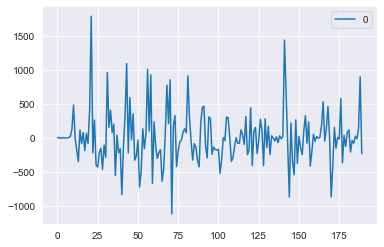

In [63]:
residuals.plot();

**Interpretation**: There seem to be some trends and cycles which indicate we have not captured those elements. In a perfect model, this plot of the residuals would look completely random.

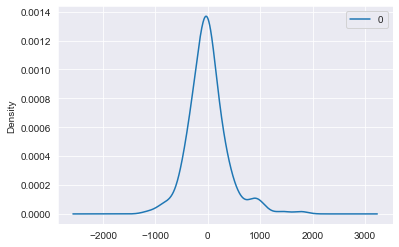

In [64]:
residuals.plot(kind='kde');

**Interpretation**: This density plot seems thaat it can be a Gaussian distribution, but it might not be centered over zero.

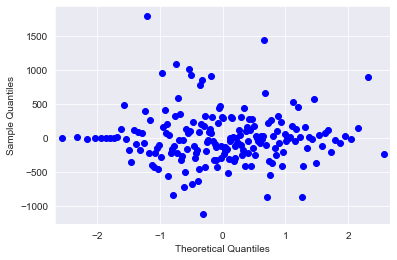

In [65]:
qqplot(residuals);

**Interpretation**:  The outliers seem to have to be having a dramatic effect on our model's residuals. 

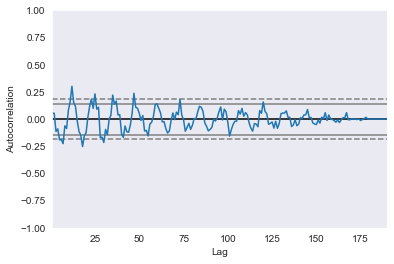

In [66]:
autocorrelation_plot(residuals);

**Interpretation**: There doesn't appear to be any clear autocorrelation trend across the plot. There may be some positive autocorrelation worthy of further investigation at lag 14, that seems significant.

### Visualizing Predictions

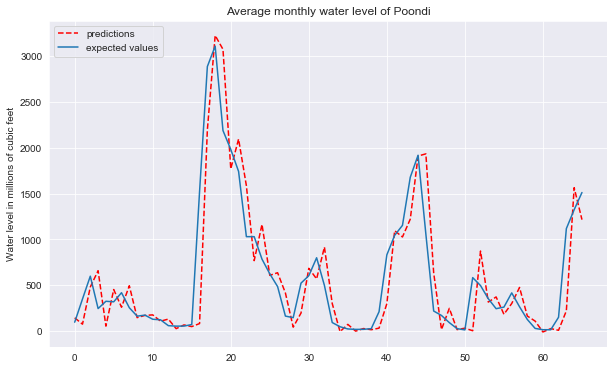

In [67]:
plt.figure(figsize=((10, 6)))
plt.title("Average monthly water level of Poondi")

plt.ylabel("Water level in millions of cubic feet")

plt.plot(predictions, color='red', ls= 'dashed', label= "predictions")
plt.plot(test, label= "expected values")
plt.legend(loc = "upper left");


**Interpretation**:The model follows fairly well with the large shocks and spikes in the data. However, there are points where the model is off. This model may need further tuning of the p,d or q.

For final thoughts and conclusions refer back to main notebook.